In [1]:
from glob import glob
from gzip import open # NB: overrides standard open()
import os
import math
import functools
import numpy as np
import scipy.interpolate
from scipy import interpolate
import pandas as pd
import pickle as pkl

def is_nan(x):
    return (x is np.nan or x != x)

# y = the regressors, a simple 2D array
y =pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/y.txt', sep= '\t')
y = y.replace(',','.', regex=True) #меняю ',' на '.'
y = y.astype(float) #конвертирую из string в float
y=y.assign(Gominy=y[["Pahokee peat","Nordic aquatic","Suwanee river","Elliot soil","Disser"]].sum(1)) #складываю столбцы
y=y.drop(["Pahokee peat","Nordic aquatic","Suwanee river","Elliot soil","Disser"], axis=1) #удаляю ненужные столбцы
y = y[['Gominy'] + y.columns[:-1].tolist()] #меняю порядок столбцов так, чтобы первым был Gominy
y.to_pickle('C:/Users/admin/Desktop/курсовая 2.0/y.pkl.gz') #сохраняем в pickle формате, удобном для регрессии
pd.set_option('display.float_format', '{:.15f}'.format) #контроль длинны вывода float
print(y)

# save the result
y.to_pickle('C:/Users/admin/Desktop/88/y.pkl.gz')

# X = the predictors, a tensor
# dimensions: (sample, emission wavelength, excitation wavelength)

# first read the text files individually
# make sure to sort the list of files, they must correspond to rows in y
X_ = [pd.read_csv(f, sep='\t') for f in sorted(glob('C:/Users/admin/Desktop/курсовая 2.0/X — копия/??.txt'))]
# sanity check: wavelengths must be the same in all files
for x in X_[1:]:
	# errors will also happen if any of the files have different dimensions
	if not ((x.axes[0] == X_[0].axes[0]).all() and (x.axes[1] == X_[0].axes[1]).all()):
		# it doesn't quite matter what we raise here
		# the important thing is to complain loudly and crash
		raise Exception(x.axes)
pd.set_option('display.float_format', '{:.15f}'.format) #контроль длинны вывода float
k = 0
X=np.zeros([35,206,55]) #инициализирую массив нулей

fds = sorted(os.listdir('C:/Users/admin/Desktop/курсовая 2.0/X — копия/')) #формируем список файлов x для считывания в цикле

xw = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/01.txt',sep='\t')
colums=list(xw.columns.values) #установил имена колонок
rows=list(xw.index.values)  #установил имена строчек
ll=xw.columns.values #колонки
lrl=xw.index.values #строчки
lrl=lrl.astype(float)
ll=ll.astype(float)
Xw=np.zeros([206,55]) #инициализирую массив нулей
cons=3400
def lo(t):
    return  1/((1/t) - (cons/1e7))
for i in range(0,206):
    for j in range(0,55):
        if (
                (math.fabs((2*ll[j])-(lrl[i]))<30) or 
                (math.fabs(ll[j]-(lrl[i]))<25) or
                (math.fabs((2*lrl[i])-(lo(ll[j])))<25) or 
                (math.fabs(lrl[i]-lo(ll[j]))<30)):
            Xw[i,j]=1.0  #собираю булеву матрицу
        
            
print(lrl)
print(ll)
print(Xw)
print(lo(lrl[17]))
print(lrl[17])
while k < 35:
    x = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/'+fds[k],sep='\t')
    fgh_copy=x
    x = x.fillna(0)
    x = x.replace(',','.', regex=True) #меняю ',' на '.'
    x = x.astype(float) #конвертирую из string в float
    Xx=np.zeros([206,55]) #инициализирую массив нулей
    for gg in range(0,206):
        tt=[]  #будущий набор из названий колонок для интерполяции
        f2=[] #значения интенсивностей для получения интерполяционного многочлена
        f3=[] #значения имён колонок для получения интерполяционного многочлена
        f5=[] #строка кусочно собранная из кусков различных интерполированных функций
        f6=[] #значения интенсивностей для получения малого интерполяционного многочлена
        f4=[] #значения имён колонок для получения малого интерполяционного многочлена
        tt1=[] #будущий набор из названий колонок для малой интерполяции
        fgh=x.iloc[gg,:]
        gh=0
        kj=0
        lk=0
        km=0
        for i in range (0,2): # заменяю в первых двух столбцах элементы на нули
            fgh.iloc[i]=0
        for i in range (50,55): # заменяю в столбцах элементы на нули
            fgh.iloc[i]=0
        if(math.fabs(1-Xw[gg,0])>0.5) and (math.fabs(1-Xw[gg,6])>0.5):
            for i in range(0,6):
                if (i<4) and (i>1): #область которую буду интерполировать
                    tt1+=[ll[i]]
                    lk+=1
                if (i<2) or (i>=4): #область данных
                    f4+=[ll[i]]
                    f6+=[fgh.iloc[i]]
        else:
            for i in range(0,6):
                tt+=[ll[i]]
                
        for i in range(6,55):
            if (math.fabs(1-Xw[gg,i])<0.5): #область для интерполяции
                tt+=[ll[i]]
                gh+=1
            if (math.fabs(1-Xw[gg,i])>0.5):  #область для получения интерполяционного многочлена
                f2+=[fgh.iloc[i]]
                f3+=[ll[i]]
                kj+=1
            
               
        if (len(f3)>1) and (len(f2)>1):  # интерполирую диагонали
            a1=scipy.interpolate.PchipInterpolator(f3,f2)
            a2=a1(tt).astype(float)
        else:
            a2=0.0
        if (len(f4)>1) and (len(f6)>1):
            a4=scipy.interpolate.PchipInterpolator(f4,f6)
            a3=a4(tt1).astype(float)
        vc=0
        cv=0 
        v=0
        v1=0
        for i in range(0,55):
            if (len(tt1)>0.5) and (v<len(tt1)):
                if (math.fabs(ll[i]-tt1[v])<1):
                    f5+=[a3[v]]
                    v+=1
            if (len(f4)>0.5) and (v1<len(f4)):
                if (math.fabs(ll[i]-f4[v1])<1):
                    f5+=[f6[v1]]
                    v1+=1
            
            if (len(f3)>0.5) and (vc<len(f3)):
                if (math.fabs(ll[i]-f3[vc])<1):
                    f5+=[f2[vc]]
                    vc+=1
            if (len(tt)>0.5) and (cv<len(tt)):
                if (math.fabs(ll[i]-tt[cv])<1):
                    f5+=[a2[cv]]
                    cv+=1
        Xx[gg,:]+=f5
        
         # теперь нужно ещё раз интерполировать, чтобы избавиться от шумов в конце
    for i in range (0,11):
        sd=[] #узлы интерполяции
        ds=[]
        for j in range (0,206): #множество которое надо интерполировать
            if (j>=80) and (j<=170):
                ds+=[j]
            else:
                sd+=[j]
            
        gj=[]
        jg=[]
        for ii in range(len(sd)):
            gj+=[lrl[sd[ii]]]
            jg+=[Xx[sd[ii],i]]
        a7=scipy.interpolate.PchipInterpolator(gj,jg)
        a8=a7(lrl[ds]).astype(float)
        ih=0
        for j in range (0,206):
            if (j<=170) and (j>=80):
                Xx[j,i]=a8[ih]
                ih+=1
                 # теперь нужно ещё раз интерполировать, чтобы избавиться от шумов в прошлом квадрате
    for i in range (80,171):
        gfg=0
        yuo=0
        f9=[]
        tr=[]
        rt=[]
        j=0
        rtr=0
        while True: #ищу максимум строчки
            if (Xx[i,j]>gfg) and (Xx[i,j+1]<Xx[i,j]):
                gfg=Xx[i,j]
                yuo=j
                break
            j+=1
        for dd in range (yuo,20):
            if (dd<=yuo+1) or (dd>=15):
                rt+=[dd]
            else:
                tr+=[dd]
        a10=scipy.interpolate.PchipInterpolator(ll[rt],Xx[i,rt])
        a11=a10(ll[tr]).astype(float)
        for ty in range (len(tr)):
            Xx[i,tr[ty]]=a11[ty]
    
    # интерполирую хвост рассеяния
    for i in range (13,30):
        ty=[]
        uy=[]
        for j in range (0,100): #хвост рассеяния
            if (j>25) and (j<75):
                ty+=[j]
            else:
                uy+=[j]
        a12=scipy.interpolate.PchipInterpolator(lrl[uy],Xx[uy,i])
        a13=a12(lrl[ty]).astype(float)
        for tg in range (len(ty)):
            Xx[ty[tg],i]=a13[tg]
    #уберу хвост рассеяния остаток
    for i in range (10,14):
        gk=0
        kg=0
        for j in range (53,70):
            if(Xx[j,i]>gk):
                gk=Xx[j,i]
                kg=j
        bnm=[23,24,25,kg]
        yh=[]
        for j in range(25,kg):
            yh+=[j]
        a16=scipy.interpolate.PchipInterpolator(lrl[bnm],Xx[bnm,i])
        a17=a16(lrl[yh]).astype(float)
        for j in range(len(yh)):
            Xx[yh[j],i]=a17[j]
    #уберу небольшие шумы в конце
    for i in range (35,55):
        tg=[]
        nb=[]
        jn=0
        nj=0
        for j in range (75,206):
            if (j==205) or (j<=80):
                tg+=[j]
            else:
                nb+=[j]
        a14=scipy.interpolate.PchipInterpolator(lrl[tg],Xx[tg,i])
        a15=a14(lrl[nb]).astype(float)
        for vz in range (len(nb)):
            Xx[nb[vz],i]=a15[vz]
    X[k,:,:]+=Xx #собираю тензор
    k = k + 1
# save the fluorescence intensity values together with wavelengths
# (like Matlab, NumPy doesn't seem to have the concept
# of "named dimensions" in >2-dimensional arrays)
pkl.dump(
	{'X': X, 'emission': X_[0].axes[0].values, 'excitation': X_[1].axes[1].values},
	open('C:/Users/admin/Desktop/88/X.pkl.gz', 'wb')
)

import matplotlib.pyplot as plt
plt.imshow(X[5,:,:],aspect="auto")
plt.show();
plt.imshow(Xx,aspect="auto")
plt.show();
plt.imshow(x,aspect="auto")
plt.show();
plt.plot(lrl,X[34,:,8])
plt.show();
plt.plot(lrl,X[34,:,11])
plt.show();
plt.plot(lrl,X[34,:,10])
plt.show();
plt.imshow(fgh_copy,aspect="auto",extent=(0, 50, 0, 50))
plt.ylabel("emission")
plt.xlabel("excitation")
plt.show();
print()
print(X[5,:,:])
print(a2)

               Gominy               Tyr               Trp
0  45.446791159494630 3.718644731004520 1.658958839543630
1  53.715968017732450 1.519253456158500 2.908843156540700
2  39.837588219318036 3.514325758417340 1.093679651809260
3  31.410666371509429 4.107808169160440 2.413379596596180
4  42.444628564694149 2.397801748277350 2.822168138776240
5  36.479939106612335 1.771191863933510 3.826667882859640
6  36.112552777464927 2.080762828858240 0.700693670286065
7  44.049333733054091 3.959066433208400 3.163624883413180
8  35.354605452902639 1.172332780942920 2.195268300827590
9  47.441840360499903 3.046103871452420 4.011520976275540
10 47.577334115601005 3.345482432441450 1.008305133569850
11 38.622682869301272 2.530966776772400 3.533569719442830
12 44.546830928591774 0.838762796009957 4.215091345623870
13 35.724430846023779 4.261242572949930 4.150725988529820
14 54.640664074782890 2.577718588091170 3.679024812424490
15 49.409746032154970 1.336313832168730 0.847237726831476
16 26.19747470

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.02237049 ... 0.         0.         0.        ]
 [0.         0.         0.02054654 ... 0.         0.         0.        ]
 [0.         0.         0.01597872 ... 0.         0.         0.        ]]
[0.0094081  0.00835896 0.00743662 0.00663755 0.0059582 ]


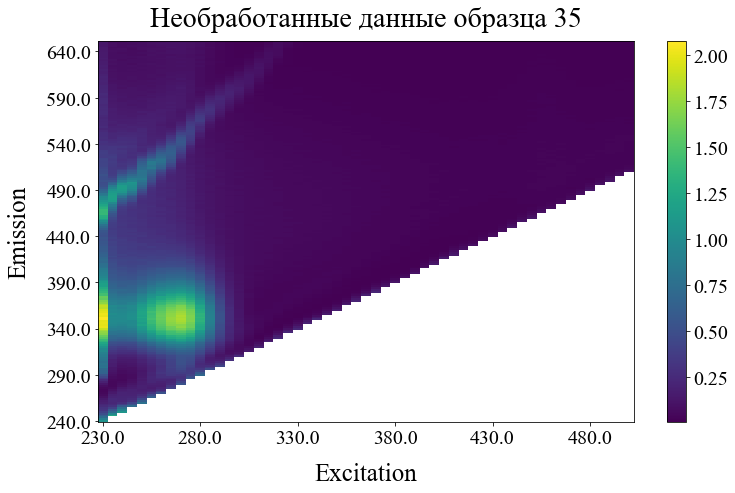

In [10]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(fgh_copy,aspect="auto", origin='lower')
plt.ylabel("Emission" , fontsize=25,labelpad=15)

plt.xlabel("Excitation",  fontsize=25,labelpad=15)
plt.title("Необработанные данные образца 35",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.yticks(indexi,high,fontsize=20)
plt.xticks(indexx,lower,fontsize=20)
plt.savefig('Необработанные данные образца 35.png', format='png', dpi=1024)
plt.show();

In [3]:
indexi=np.arange(0,225,25)

In [4]:
high=lrl[indexi]

In [5]:
high

array([240., 290., 340., 390., 440., 490., 540., 590., 640.])

In [6]:
indexx=np.arange(0,60,10)

In [7]:
lower=ll[indexx]

In [8]:
lower

array([230., 280., 330., 380., 430., 480.])

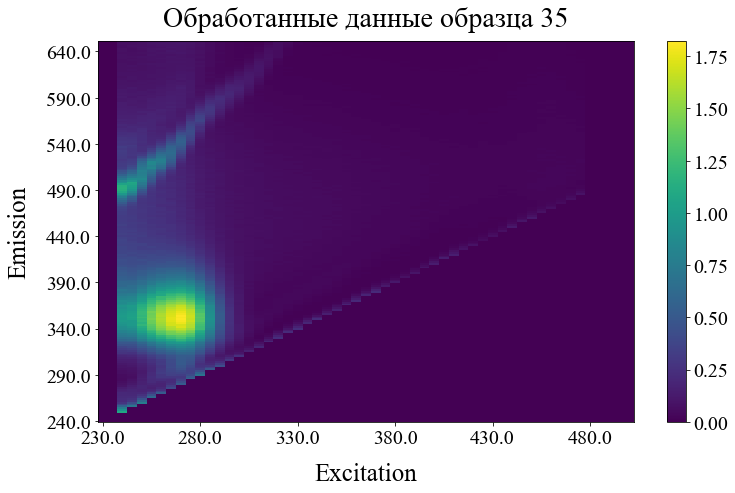

In [12]:
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(x,aspect="auto", origin='lower')
plt.ylabel("Emission" , fontsize=25,labelpad=15)

plt.xlabel("Excitation",  fontsize=25,labelpad=15)
plt.title("Обработанные данные образца 35",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.yticks(indexi,high,fontsize=20)
plt.xticks(indexx,lower,fontsize=20)
plt.savefig('Обработанные данные образца 35.png', format='png', dpi=1024)
plt.show();

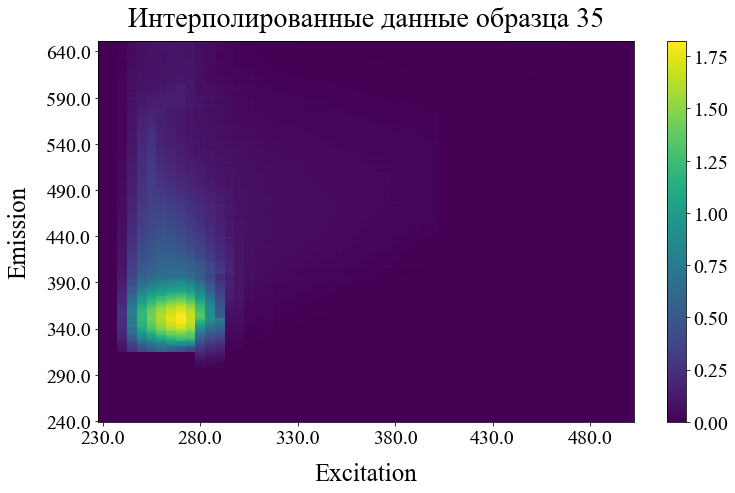

In [13]:
mpl.rc('font',family='Times New Roman')
plt.figure(figsize=(12,7))
plt.imshow(Xx,aspect="auto", origin='lower')
plt.ylabel("Emission" , fontsize=25,labelpad=15)

plt.xlabel("Excitation",  fontsize=25,labelpad=15)
plt.title("Интерполированные данные образца 35",  {'fontname':'Times New Roman'}, fontsize=28,loc="center" ,pad=15)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.yticks(indexi,high,fontsize=20)
plt.xticks(indexx,lower,fontsize=20)
plt.savefig('Интерполированные данные образца 35.png', format='png', dpi=1024)
plt.show();